<a href="https://colab.research.google.com/github/ocansey11/computer-vision/blob/main/Final_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- <div style="text-align: center; margin: 0 auto; max-width: 800px;">

  <img src="https://raw.githubusercontent.com/gerryfrank10/ComputerVision/main/assignment/brand.gif" alt="Bournemouth University" style="width: 500px; margin: 0 auto; display: block;">

  <h1 style="text-align: center;">Department of Computing & Informatics </h1> -->

<p align="center">
  <img src="https://raw.githubusercontent.com/gerryfrank10/ComputerVision/main/assignment/Bournemouth-University.jpg" alt="Bournemouth University" width="300", height="300">
</p>
<p align="center">
  <strong>Department of Computing & Informatics </strong>
</p>

<!-- <hr style="max-width: 800px; margin: 20px auto;"> -->


<br />

  <p align="center"><b>Project Title </b>: Knapsack Problem Using Computer Vision</h1>

<br />
<br />
<br />

  <p align="center">
  <strong>Students:</strong><br>
  Kevin Ocansey &nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp; Gerald Amasi &nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp; James Foster
</p>

<br />
<br />
<br />

<p align="center">
  <strong>Course:</strong> MSc Data Science & Artificial Intelligence<br>
  <strong>Supervisor:</strong> Marcin Budhka<br>
  <strong>Academic Year:</strong> 2024/2025
</p>

</div>

<hr style="max-width: 800px; margin: 20px auto;">

## Abstract
This project explores the integration of computer vision and mathematical optimization to automate the 2D packing of items into a container. Motivated by real-world logistics and warehousing applications, we developed a modular pipeline that first detects object dimensions from top-down images and then computes efficient placement using discrete optimization. For object detection, we evaluated both YOLOv8 and Faster R-CNN base models, using a physical reference (a ruler) within the scene to convert bounding box dimensions from pixels to real-world units. Bounding box precision was enhanced using OpenCV contour analysis and furthur experiments for bounding box precision was done on Roboflow, with data augmentation applied to increase robustness. In parallel, we trained a ResNet-based classifier using the Open Images dataset to improve object identification accuracy.

On the optimization side, we modeled the packing task using Pyomo as an Integer Linear Programming (ILP) problem with binary placement variables over a discretized grid. Experiments revealed a trade-off between grid resolution and solver feasibility: finer grids offered more placement flexibility but resulted in millions of variables and infeasible solve times, while coarser grids significantly improved runtime with minor losses in spatial efficiency. The ILP model succeeded in computing non-overlapping layouts for various configurations, though extreme cases required manual tuning. These challenges prompted the exploration of alternative metaheuristic approaches, including a Genetic Algorithm (GA) built upon a greedy packing strategy, and a Simulated Annealing (SA) method incorporating additional constraints such as item rotation within the grid. Both approaches aim to provide more scalable and flexible solutions for complex packing configurations.

Our findings demonstrate the feasibility of combining object detection and mathematical programming for automated packing, while highlighting practical limitations in resolution control, solver scalability, and real-world image noise. Future improvements include deeper model training, real-time scale calibration, and continuous-space optimization methods.

## Introduction

The efficient use of space is a universal logistical challenge. Whether in shipping containers, warehouse shelving, delivery vans, or even digital storage, the need to fit multiple entities into limited space optimally is ever-present. This packing problem becomes significantly more complex when items vary in shape and size. With the rapid advancement of artificial intelligence and computer vision technologies, the possibility of automating this process has attracted growing attention. For example, Hanif et al. (2020) explored the application of neural network-based solvers for knapsack-like problems, demonstrating how even non-state-of-the-art methods can offer valuable alternatives for tackling such optimization challenges. Similarly, Franco et al. (2016) investigated how humans approach discrete optimization tasks like the knapsack problem, highlighting how problem complexity is perceived and solved differently in cognitive science versus computer science.

<br/>

While algorithmic solvers have evolved, object detection remains central to any vision-based packing system. YOLO-based detectors (e.g., YOLOv3 and YOLOv5) are widely known for their real-time inference capabilities, although they can struggle with small, occluded, or deformed objects (Tan et al., 2021). By contrast, two-stage detectors like Faster R-CNN, especially those augmented with ResNet backbones and deformable convolutions, have been shown to improve performance on complex scenes such as airports (He & He, 2025).

<br />

This type of spatial optimization is applicable across a wide range of domains from efficiently filling shopping baskets in supermarkets to warehouse logistics and industrial inventory management. Our project addresses a specific variation of this challenge: using a top-down camera to detect a set of items on a surface and determine whether they can fit into a predefined container. If placement is feasible, the system then estimates an optimal arrangement. The intended impact of this approach is to support automation efforts in settings such as e-commerce warehouses, moving logistics, and industrial manufacturing operations.


##Problem Definition

This packing challenge is closely related to variations of the ***knapsack and bin-packing problems*** in combinatorial optimization. The classic knapsack problem focuses on selecting items to maximize value within a weight constraint, and most versions consider, ie. taking into account weight, height, and length. The 2D bin-packing problem, by contrast, focuses only on item dimensions and spatial arrangement.
In addition, existing solutions for these problems typically assign a value to each item being placed in the bin or knapsack. The goal is to choose the best combination of items to maximize total value. We’ve slightly changed the objective in our problem to focus on optimizing space.
What makes our approach different is that we don’t assign any value to the items, all items are treated equally. For our problem, we only care about whether the items fit and how efficiently we can arrange them. So instead of maximizing value, our goal is to minimize the space used within the container. We even have more items in question than the box could take so our algorithms can leave some out

### Rationale

With the large growth of online shopping over the last decade, logistics has increased in global importance. More efficient packing leads to fewer shipments that are underutilising space, and so saving both space and time in packing scenarios is important. Packing items manually takes time and is prone to errors, leading to extra delays or non-optimal packing solutions.

### Aims and objectives

Our problem can be broken down into two primary objectives:

* Feasibility Evaluation: Can the given set of detected items be arranged to fit within a designated container?
* Optimization: If yes, what is the best way to arrange them to minimize wasted space, reduce the number of containers, or improve another metric of interest?


We approach this through a layered strategy. First, we process visual data using computer vision to identify and extract item characteristics, primarily their two-dimensional dimensions (width and height). Then, we pass this information to an algorithm that attempts to virtually place the items into a container.


## Data acquisition and preparation

### Data Characteristics and Statistics

#### Data Collection (Manually)
<p align="center">
  <img src="https://raw.githubusercontent.com/gerryfrank10/ComputerVision/main/assignment/datasets/im1-ref1.JPG" alt="Multiple Bounding Boxes" width="300", height="300">
</p>
<p align="center">
  <strong>Fig 1 : </strong> Example Image Collected Manually
</p>

We collected real-world images of various objects using a mobile camera. These images reflect natural conditions, including different lighting, angles and occultation. The objects vary in shape, and texture, mimicking realistic scenarios in which the system must identify and pack items efficiently
For the collected images, over an iteration of testing and validating models detection performance, we propose an approach to use in capturing the images which include
- Plain Background surface: The objects were placed on a plain surface with varying solid colors. This minimizes the background noise and enhances object boundary clarity, improving detection accuracy
- Camera position and orientation: We also used consistent camera position to reduce the perspective distortion and improve object size estimation, the camera was mounted at a fixed height and angle. This consistency ensures uniformity in the dataset and aids in training the model effectively
- Controlled lighting Conditions: Adequate lightning was used to avoid harsh shadows and reflections. When possible natural daylight was applied
- Multiple angles and rotations: While maintaining controlled conditions, we captured each object from different angles and slight rotations to expose the model to minor variations in orientation and shape perception

<hr />

#### Open Image Dataset

<p align="center">
  <img src="https://storage.googleapis.com/openimages/web/images/crowdsource_dataset_3x3_example_a.png" alt="Image Dataset" width="300", height="300">
</p>

<p align="center">
  <strong>Figure : </strong> Example image from the Open Images Dataset.
</p>

The data used for this project is derived from the Open Images dataset, which is a comprehensive resource for object detection, segmentation, and classification. Specifically, the subset we are working with contains bounding boxes, object segmentations, visual relationships, and localized narratives for 600 different object classes. This dataset spans across:

- 1,743,042 training images,

- 41,620 validation images,

- 125,436 test images.

We can apply filtering to isolate images that contain our target classes. This can come in handy to ensure retraining and specification for particular items we want for different context. The Dataset included *downloader.py* file which can help in downloading the images.
```bash
usage: downloader.py [-h] [--num_processes NUM_PROCESSES]
                     [--download_folder DOWNLOAD_FOLDER]
                     image_list

Open Images image downloader.

This script downloads a subset of Open Images images, given a list of image ids.
Typical uses of this tool might be downloading images:
- That contain a certain category.
- That have been annotated with certain types of annotations (e.g. Localized
Narratives, Exhaustively annotated people, etc.)

The input file IMAGE_LIST should be a text file containing one image per line
with the format <SPLIT>/<IMAGE_ID>, where <SPLIT> is either "train", "test",
"validation", or "challenge2018"; and <IMAGE_ID> is the image ID that uniquely
identifies the image in Open Images. A sample file could be:
  train/f9e0434389a1d4dd
  train/1a007563ebc18664
  test/ea8bfd4e765304db

positional arguments:
  image_list            Filename that contains the split + image IDs of the
                        images to download. Check the document

options:
  -h, --help            show this help message and exit
  --num_processes NUM_PROCESSES
                        Number of parallel processes to use (default is 5).
  --download_folder DOWNLOAD_FOLDER
                        Folder where to download the images.
                      
```

For example packing items for a trip. Making our custom model lightweight. So for our given scenario lets say we focused on packing these three items ("Spoon", "Plates", "Book"), which helped us narrow down the dataset to a total of 10,330 images.



### Data Processing
Once the images are filtered to only include the target classes, the following preprocessing steps can be applied.


* Bounding Box Information: The dataset provides bounding box coordinates for each object in an image. We'll extract the coordinates for each target class to ensure proper identification and scaling for later processing in the packing algorithm.

* Image Resizing: To standardize the images and make them compatible with the algorithm, we may need to resize the images to a consistent dimension. This helps in reducing computational load and ensuring uniformity across the dataset.

* Data Augmentation: To increase the diversity of the dataset and improve the robustness of the model, we may apply augmentation techniques like rotation, flipping, and cropping. This will simulate various real-world scenarios for item placement and packing.

* Feature Extraction: We will extract key features like the item’s width, height, and aspect ratio from the bounding boxes. This is essential for determining if the items can fit within a specified container.

* Splitting Data: The dataset will be split into training, validation, and test sets. This is critical for training the model, tuning hyperparameters, and evaluating the model's performance.

### Data Visualization
To help in understanding the dataset, visualizing some of the images and their corresponding bounding boxes can help verify that the correct items are being captured. A few steps to visualize the data might include.

We used a function to display images which plots single image or multiple image


In [ ]:
import numpy as np; import matplotlib.pyplot as plt; import cv2
def show_img(im, ax=None, figsize=(8,8), title=None):
    if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2: im = np.tile(im[:,:,None], 3)
    ax.imshow(im);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    if title: ax.set_title(title)
    return ax
def show_imgs(ims, rows=1, figsize=(16,8), title=[None]):
    title = title*len(ims) if len(title) == 1 else title
    _,ax = plt.subplots(rows, len(ims)//rows, figsize=figsize)
    [show_img(im,ax_,title=tit) for im,ax_,tit in zip(ims,ax.flatten(),title)]
    return ax

Distribution of Classes:

Visualizing the distribution of bounding boxes for the target classes (e.g., how many bounding boxes correspond to plates vs. spoons vs. books).

## Modelling : Why YOLOv8, ResNet50,OpenCV, FastRCNN Pretrained Model

### YOLOv8: Precision in Object Detection

**YOLOv8** (You Only Look Once version 8) is a state-of-the-art, real-time object detection model known for its speed and accuracy. Its architecture is optimized for detecting multiple objects within an image, making it particularly suitable for scenarios where numerous items need to be identified and localized simultaneously.

- **Real-Time Processing**: YOLOv8 processes images in real-time, enabling immediate feedback on object detection, which is crucial for dynamic environments.
- **High Accuracy**: It achieves a high mean Average Precision (mAP), ensuring reliable detection of objects, even in cluttered scenes.
- **Versatility**: The model is adept at handling various object sizes and orientations, a common challenge in packing problems.

These attributes make YOLOv8 an excellent choice for detecting and localizing items in a packing scenario, providing the foundational data needed for subsequent optimization steps.

### ResNet50: Robust Feature Extraction

**ResNet50** is a deep convolutional neural network that utilizes residual learning to facilitate the training of very deep networks. Its architecture includes 50 layers with skip connections, allowing for the effective learning of complex features without the risk of vanishing gradients.

- **Deep Feature Learning**: The residual blocks enable the network to learn intricate patterns and features, which are essential for understanding the spatial relationships between objects.
- **Transfer Learning**: Pretrained on large datasets like ImageNet, ResNet50 can be fine-tuned for specific tasks, reducing the need for extensive training data and computational resources.
- **Versatility**: Its robust feature extraction capabilities make it suitable for various applications, including object detection and image classification.

In the context of the 2D knapsack problem, ResNet50 can be employed to extract detailed features from the detected objects, aiding in the accurate assessment of their dimensions and spatial properties.

###  OpenCV: Essential Preprocessing for Image Data

**OpenCV** (Open Source Computer Vision Library) is a powerful tool for computer vision tasks, providing a wide range of utilities for image processing. When applied to the packing problem, OpenCV can significantly enhance the quality of input data before it is fed into more complex models like YOLOv8 and ResNet50.



In order to increase the performance of the various models we suggest the following we will work with such as Fast R-cnn, Yolov8 we suggest the follwoing

1. Minimize the problem domain: As we have already done. Limiting the images we will train on to four items. That is making use of the model to few search spaces (Intentionally over training to make it lightweight). Example if our context is we are concerned about filling books and DVD’s in the library, then we use a  pre-trained model with a dataset containing these particular images to make it efficient to determine the objects with high confidence.

2. Performing Data Augmentation, with the dataset we collected, tailored to domain specific we perform data augmentation techniques to the dataset, so that we can get to have the model with base knowledge of items,

### Choosing Appropriate Techniques

We approached the 2D packing problem by integrating object detection, vision-based measurement correction, and mathematical optimization into a streamlined and automated pipeline. The system begins with the assumption that all items and the container are captured in a single top down image, where objects are unobstructed, rectangular, and aligned with the axes.

#### a) Object Detection (Faster R-CNN / YOLOv8)

To detect and localize the items within the input image, we used object detection models such as YOLOv8 and Faster R-CNN. These models, trained on datasets like COCO, were either used directly or fine tuned for our custom classes when needed. Each model outputs bounding boxes for detected items, with coordinates representing their pixel based height and width. This step provides the initial structural information required for spatial reasoning and optimization. The simplicity of our visual scenes, high contrast, fixed camera, and minimal clutter allowed us to achieve consistent detection results in most cases.

#### b) Dimension Verification (OpenCV)

Although deep learning models provide bounding boxes, we incorporated a verification and calibration step using OpenCV to enhance measurement reliability. Using `cv2.findContours` and `cv2.contourArea`, we were able to detect edges and isolate object outlines, filtering out noise and irrelevant detections. By placing a known size reference object (e.g., a coin or printed square) in each frame, we converted all pixel based measurements into real world units. This calibration process ensures that every item’s size is consistent with the scale of the container and suitable for accurate optimization.

#### c) Optimization Model (Pyomo)

After obtaining reliable width and height values for each item, we formulated the packing problem using Pyomo as a mixed integer linear program (MILP). The container was discretized into a grid, and each item was mapped to a corresponding number of grid cells based on its real-world dimensions. The optimization variables defined where each item could be placed and whether it should be rotated by 90 degrees. Constraints were imposed to prevent overlapping placements and to keep all items within the container boundaries. The optimization objective aimed to minimize unused space, effectively maximizing packing efficiency. This model serves as the decision-making core of the system.

---



### 2. Well-Organized Approach

The overall system was designed as a modular pipeline with clearly defined stages. Images are first passed through the detection module to extract item bounding boxes. These are then refined through OpenCV-based measurement correction before being passed to the optimization module. Each stage can be tested and improved independently, supporting iterative development and debugging.

Validation of the pipeline was done using a synthetic dataset of rectangular items placed on known backgrounds. We created ground-truth packing scenarios and compared them to the system’s predicted arrangements, assessing correctness visually and quantitatively. This setup also allowed benchmarking of solver speed and placement accuracy under different configurations.

---



### 3. Subsequent Steps Informed by Earlier Findings

Early experimentation revealed that object detectors occasionally failed to produce accurate or complete bounding boxes. To mitigate this, we introduced an OpenCV-based fallback mechanism for contour verification. We also implemented a pre-optimization feasibility check by comparing the total area of detected items against the container area to eliminate clearly unsolvable cases.







<p align="center">
  <img src="https://raw.githubusercontent.com/ocansey11/computer-vision/main/subsequent%20steps/multiple%20bounding%20boxes.png" alt="Multiple Bounding Boxes" width="auto", height="auto">
</p>
<p align="center">
  <strong>Fig 2 : </strong> Multiple bounding boxes from initial code
</p>


Additionally, we improved detection quality by raising the score threshold used
during the filtering phase of the fasterrcnn model. By only retaining predictions above a confidence level of 0.8, we reduced false positives and ensured that only high-certainty detections were passed to the optimization stage.

```python

    detections = []
    for i, box in enumerate(predictions[0]['boxes']):
        label_idx = predictions[0]['labels'][i].item()
        label = coco_labels[label_idx]
        # Make a condition to increase filtering of bounding boxes
        if label in labels_of_interest and predictions[0]['scores'][i].item() > 0.8:
            detections.append({
                'label': label,
                'bbox': box.tolist(),
                'score': predictions[0]['scores'][i].item()
            })

    return detections, image_path
  


<p align="center">
  <img src="https://raw.githubusercontent.com/ocansey11/computer-vision/main/subsequent%20steps/correct%20bounding.png" alt="Multiple Bounding Boxes" width="auto", height="auto">
</p>
<p align="center">
  <strong>Fig 3 : </strong> Filtering score produces only really high scored bounding box
</p>




Note:
A good thing from these helped us understand if we want to work with bounding boxes and get our width and height correctly we needed to arrange the books in a way that reduces gaps in bounding box

OpenCv being our fall back we also observed some limitations with it. Mostly due to our setup. For example changing the background and lighting conditions significantly affected object detection accuracy with OpenCv.





<p align="center">
  <img src="https://github.com/ocansey11/computer-vision/blob/main/subsequent%20steps/opencv%20img.jpeg?raw=true" alt="Multiple Bounding Boxes" width="auto", height="auto">
</p>
<p align="center">
  <strong>Fig 4 : </strong> OpenCv contours detects shadows and other things in background
</p>






When we used a white background and diffused lighting, the results improved — contours were more distinct, and the bounding boxes were better aligned with object edges.

However, even with these improvements, some objects were still not detected, especially when their color or texture closely matched the background.

This led to inconsistent bounding boxes, often cutting off parts of the objects or leaving excess space. In other words, the accuracy of object detection felt a bit like luck.

These limitations pushed us to consider more robust solutions. While OpenCV provides helpful preprocessing tools, we realized that relying solely on manual setups isn't sustainable. That’s why we started exploring deep learning-based models for more consistent and scalable object detection

![Preprocessing steps](https://github.com/ocansey11/computer-vision/blob/main/subsequent%20steps/opencv%20sucess.png?raw=true)

Here we also show the output from both models including yolo, pretrained, and resnet50.

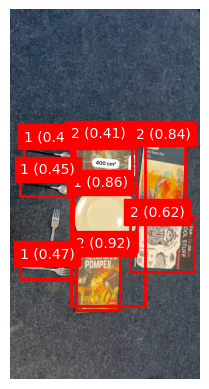

> Also here for the resnet50 model


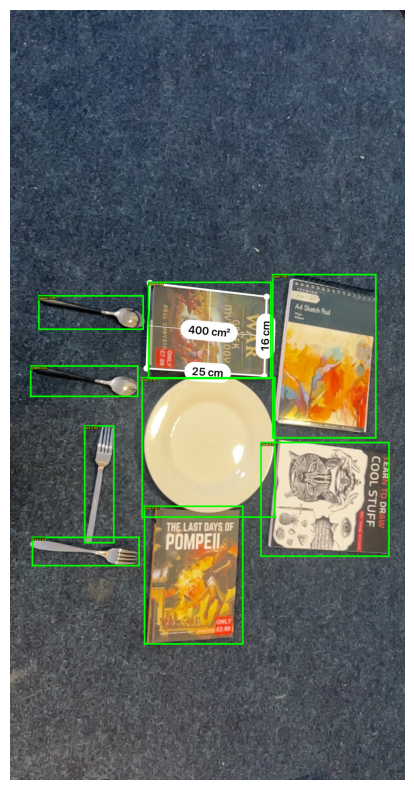

> So the pipeline and perfomance of the model over iterations to include get the best out of the model.

This iterative process showed a significant chances in detecting, and having a high confidence values in detecting.

### Challenges in Grid-Based and Optimization-Driven Packing

During the early phases of our project, we adopted a randomized grid based strategy for item placement. Items were inserted into the discretized container by randomly assigning positions based on width and height constraints, and we evaluated each trial by the amount of empty space left. While this brute-force strategy provided a useful visual baseline, it was quickly found to be computationally expensive and suboptimal, especially when item counts increased.

A major realization was that naïvely placing all items at once failed to account for spatial dependencies. As a result, we revised our strategy to align items sequentially, one at a time, prioritizing space efficiency rather than uniform placement randomness. This shift marked a significant philosophical and computational change: the goal was no longer to fit all items, but rather to fit as many as possible, introducing selectivity and prioritization into the packing pipeline.

In parallel, we explored mathematical optimization using Pyomo, an open source modeling language for expressing optimization problems in Python. However, this revealed its own limitations. When the model could not find a feasible solution particularly under strict constraints or small grid unit sizes—the solver often failed to return partial placements. Instead, it rejected the configuration altogether, resulting in zero item placements (GLPK Solver output, see Fig. 2). This exposed a critical drawback of relying exclusively on traditional Integer Linear Programming (ILP) for flexible, real-world packing scenarios (Martello and Toth, 1990; Silva et al., 2021).

### Refinements and Key Improvements
These challenges catalyzed several innovations in our pipeline. Our early manual simulations drawing items on grid paper proved invaluable. By simulating rotation edge cases and boundary violations manually, we identified latent constraints that needed to be explicitly encoded. This visual-spatial reasoning helped shape our constraint logic, particularly for overlap avoidance and rotation feasibility.

A particularly impactful refinement was the grid unit parameter. Initially hardcoded, we later exposed it as a tunable configuration, discovering its direct impact on solver complexity. Small units (e.g., 10) created millions of binary decision variables, overwhelming solvers. Coarser units (e.g., 30 or 50) drastically improved performance with minor accuracy trade offs. This insight turned grid resolution into an optimization lever in its own right a balance between computational feasibility and spatial precision.

Additionally, the insight that ILP solvers may not always return best-effort solutions led us to consider more adaptive algorithms like Genetic Algorithms (GAs). These heuristic methods offer flexibility by evolving placement strategies over generations and are robust under looser constraints, even if they sacrifice theoretical optimality (Mitchell, 1998). Though still under development, GA variants are positioned as viable alternatives for real time or large-scale packing tasks.


### Benchmarking and Dataset Generation
In order to evaluate the robustness and scalability of our packing algorithms, we grounded our experiments on well-established benchmark datasets. A key dataset used during early benchmarking was the one introduced by Elhedhli, Gzara, and Yildiz (2019). Their dataset is known for representing realistic three-dimensional bin packing problems, particularly in contexts like mixed-case palletization, and includes realistic volume distributions, load-bearing constraints, and stacking logic.

Since our problem domain was focused on 2D packing, we projected the 3D item dimensions from the Elhedhli dataset onto a 2D plane, treating each item as a flat rectangle defined by its width and depth. This projection was done while preserving relative scale and proportions, ensuring that our 2D simulations reflected meaningful geometric diversity.

However, as our experiments progressed, we needed a way to generate new item configurations flexibly — with control over parameters like dimension ranges, weight distributions, affinities, and incompatibilities. To achieve this, we integrated the Q4RealBPP DataGen tool developed by TECNALIA (2023), an open-source Python-based generator designed for bin packing research and simulation.

Using this tool, we created a new synthetic dataset of rectangular items by replicating the statistical distributions of dimensions found in Elhedhli et al.’s work. The generator leverages log-normal and normal distributions to simulate realistic variation in item sizes, aspect ratios, and volume categories. We configured parameters such as:

Number of categories and items (e.g., 15 categories, 50 total items),

Ranges for width, height, and depth (e.g., 0–1000 units),

Weight range per item (20–50 units),

Optional features like positive affinities and incompatibilities between items.

This allowed us to produce large, varied batches of packing instances for stress-testing both ILP and heuristic solvers under controlled but realistic conditions.

Our generated dataset was output in .txt format for solver ingestion, and all data were stored in Pandas-compatible formats for reproducibility and auditability. Importantly, we designed the generation process to be repeatable, ensuring consistent experimental conditions across solver configurations



---

### 4. Automation (Avoiding Manual Steps)

From start to finish, the pipeline is designed for full automation. Once an image is placed in the input folder, the system processes it through detection, dimension correction, optimization, and visualization without requiring human intervention. All measurements are extracted, scaled, and passed to our different algorithms to provide a structured placements. The placements contain

The final arrangement is rendered on the original image or a blank grid, showing the optimized layout for review. In batch mode, the system can process an entire dataset of item and container images, making it practical for deployment in warehouse environments or packing line simulations.

While our current implementation focuses on 2D, axis-aligned, rigid items, the underlying architecture supports future extensions. These could include 3D stacking, deformable object modelling, or even real-time decision-making via reinforcement learning.

By structuring the pipeline this way, we ensure it is not only effective for the problem at hand but also extensible and robust to evolving constraints.





### Subsequent steps informed by earlier finding



### Limitations of this approach

For this approach there are few limitations including
* There should be a reference object in the image, this is impractical solution in real world scenario where having a reference object can be hard to obtain in different scenarios
* Items in the image space have to be aligned together, an example is taking an image of a person facing the sun, making the person bigger than the sun but in reality, the sun is bigger than the person. The reality is that having objects closer to each other and the position of the camera is an important factor to estimate  the size of objects. This is one of the factors that is beyond the scope of our project.

## Evaluation:



### Comparison of Object Detection Models

| Model Name     | Avg Estimation Accuracy (1–5) | Inference Time | Notes                                                                                             | Overall Score (1–5) |
|----------------|-------------------------------|----------------|---------------------------------------------------------------------------------------------------|---------------------|
| CV2 - Contour  | 1.0                           | ~0.05s         | Very fast but only detects shapes; no object classification or semantic understanding.            | 1                  |
| YOLOv8         | 2.5                           | ~0.23s         | Good balance of speed and basic accuracy; struggles with small or occluded objects.               | 3                   |
| YOLOv10        | 4.0                           | ~0.21s         | Improved over v8 in accuracy and label consistency; fastest overall in detection runtime.         | 4                   |
| Faster R-CNN   | 4.0                           | ~7.7s          | High accuracy, especially for cluttered scenes and overlapping items; slowest among all models.   | 4                 |



With the comparison of both models included in the summary, (Fater Rcnn ) shows high performance compared to other models. This project concludes that the (_ Model) with proper calibration can be used to improve the model estimation performance.


Comparison between Our Models with Practical Apple IOS Model

* The models we selected are best in detecting multiple objects in image simultaneously, compared to the IOS Model which detects and determines the shape of objects one at a time
* Using a pretrained model like fast-RCNN trained on COCO dataset,  we can detect the labels of our images and annotate them effectively, this implies a practical instance in Knapsack problems that involve importance of the object meaning the important object to be packed. The IOS model doesn’t include the labels of detected shapes in image, But this if only in the measurement Application, We believe this functionality can be added to their existing model to annotate the labels to the images.

So for faster, efficient, and proper determination with other characteristics it's better to use a pretrained model, and train it to the dataset or data properties you would like to include.







### Mapped Detected Objects and Their Dimensions

This table maps the detected objects from the YOLOv8 model to their real-world counterparts using visual inspection and estimated dimensions from image annotations. Items like forks and spoons appear multiple times and are noted with a dash in repeated entries.

| Detected Label | Mapped Object           | Score  | Detected Width (cm) | Detected Height (cm) | Actual Dimensions (cm) | YOLO | Faster R-CNN |
|----------------|--------------------------|--------|----------------------|-----------------------|-------------------------|------|---------------|
| fork           | Fork                     | 0.99   | 4.73                 | 21.18                 | 21 × 3.0                | 1    | 1             |
| book           | Learn to Draw Cool Stuff | 0.97   | 16.00                | 25.00                 | 27.5 × 21.5             | 0    | 1             |
| spoon          | Spoon                    | 0.95   | 17.42                | 5.55                  | 20 × 3.5                | 1    | 1             |
| fork           | Fork                     | 0.94   | 17.34                | 5.14                  | -                       | 0    | 1             |
| spoon          | Spoon                    | 0.88   | 16.95                | 6.04                  | -                       | 1    | 1             |
| book           | Sketchpad                | 0.86   | 16.79                | 29.68                 | 29.5 × 20.5             | 1    | 1             |
| book           | Pompeii Book             | 0.75   | 20.84                | 20.63                 | 24.5 × 17               | 1    | 1             |
| bowl           | Bowl                     | 0.45   | 21.63                | 25.30                 | 25 × 25                 | 1    | 1             |
| book           | War in Greek Mythology   | 0.44   | 19.91                | 17.50                 | 24 × 16                 | 0    | 1             |




#### Step 1: Average Detected Dimensions
For each object class (e.g., "book", "fork", "spoon"), we had multiple detections from the model. We computed the **mean predicted width and height**:

- **Avg Width (W̄ₚ)** = (W₁ + W₂ + ... + Wₙ) / n  
- **Avg Height (H̄ₚ)** = (H₁ + H₂ + ... + Hₙ) / n

Where:
- Wᵢ and Hᵢ are the individual detected widths and heights (in cm)
- n = number of detections for that object class

#### Step 2: Reference Actual Dimensions

- **Actual Width (Wₐ)**
- **Actual Height (Hₐ)**

Due to object rotation, **width and height are treated as interchangeable**.

#### Step 3: Area Error
The predicted and actual area were computed as:

- **Predicted Area (Aₚ)** = W̄ₚ × H̄ₚ  
- **Actual Area (Aₐ)** = Wₐ × Hₐ

Then, the **percentage error** is:

**Area Error (%)**  = |( W̄ₚ × H̄ₚ ) − ( Wₐ × Hₐ )| / ( Wₐ × Hₐ ) × 100




### Object Detection Accuracy and Error Analysis

We compared the average predicted dimensions of objects detected by our models (e.g., YOLO) against the actual real-world dimensions measured with a ruler. Since items were sometimes rotated, width and height are treated interchangeably. For simplicity, one reference item was used per class (e.g., one spoon, one fork, one book). The area error was calculated as a percentage deviation between the detected area (width × height) and actual area.

| Label | Avg Detected Width (cm) | Avg Detected Height (cm) | Actual Width (cm) | Actual Height (cm) | Area Error (%) | Width Error (%) | Height Error (%) |
|-------|--------------------------|---------------------------|-------------------|--------------------|----------------|------------------|-------------------|
| book | 16.00 | 25.00 | 27.5 | 21.5 | 32.35% | 41.82% | 16.28% |
| fork | 11.04 | 13.16 | 21.0 | 2.2 | 214.33% | 47.45% | 498.18% |
| spoon | 17.19 | 5.79 | 20.0 | 3.5 | 42.27% | 14.07% | 65.57% |


<p align="center"> <i> Table : Area Error (%)  = |( W̄ₚ × H̄ₚ ) − ( Wₐ × Hₐ )| / ( Wₐ × Hₐ ) × 100 </i> </p>

**Notes:**
- The models detect bounding boxes, which may include margin areas, shadows, or overlapping objects.
- Multiple styles of forks and spoons were present, so exact alignment between instances and ground truth may vary.
- Despite some high percentage errors especially for slender objects like forks the predictions were visually centered and useful for coarse spatial layout.
For future works, a proper setup can achieve better results. with tripods and a professional camera we can shoot with little margin of error as low as 10%


### Discussion and achievement of objective

### Comparison of Simulated Annealing and Genetic Algorithm

| Metric                  | Simulated Annealing | Genetic Algorithm |
|-------------------------|---------------------|-------------------|
| Runtime                 | 4.20 seconds        | 75.34 seconds     |
| Best Cost (fitness)     | -1,055,960          | -781,311          |
| Unplaced Items          | 7                   | 10                |
| Iterations / Generations | 500 annealing steps | 15 generations    |
| Speed                   |  Fastest           |  Much slower     |
| Packing Success         |  Fewer failures    |  More failures   |
| Cost Optimization       |  Better            |  Worse           |



### Observations:

- **Simulated Annealing (SA)** significantly outperformed GA in this scenario. It was ~18× faster and resulted in both a **better cost** and **fewer unplaced items**.
- **Genetic Algorithm (GA)** required more computation time per generation, and although it's more flexible for diverse constraints or continuous representations, it didn’t converge as effectively in this case.
- **Best Cost** is negative because it’s used as a minimization metric (e.g., negative of total packed value or negative free space).
- These results reflect this specific test instance and may vary under different problem sizes or configurations.

### Reproducibility


In [ ]:
import random;import torch
def set_seeds(seed_value=42):
  """Set seed for reproducibility."""
  random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

set_seeds()

## Appendix:



 In this section we are going to include all the coding pipeline in this project. Start by installing dependencies

Installing the packages

In [ ]:
!sudo apt update
!sudo apt-get install -y glpk-utils
!pip install torchvision torch opencv-python matplotlib numpy pandas pyomo boto3 requests ultralytics

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
35 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

Importing all necessary libraries

In [ ]:
import requests
import os
import zipfile
import pathlib
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torchvision
import pyomo
from pyomo.environ import SolverFactory
from pyomo.environ import *
import pyomo.environ as pyo
import importlib.util
import cv2
from PIL import Image, ImageDraw, ImageFont
from matplotlib import patches
import torchvision.transforms as T
import time
from ultralytics import YOLO
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm, trange

import math
import importlib.util
import urllib.request

include downloader for Open Image Dataset

In [ ]:
with open('downloader.py', 'wb') as f:
    f.write(requests.get('https://raw.githubusercontent.com/openimages/dataset/master/downloader.py').content)

downloading datasets

In [ ]:
'''
This code depends if you cant find the dataset for any reason in the file then download this dataset.
'''
url = 'https://github.com/gerryfrank10/ComputerVision/raw/refs/heads/main/assignment/datasets/images.zip'
!wget {url}
!unzip images.zip

--2025-05-15 21:15:09--  https://github.com/gerryfrank10/ComputerVision/raw/refs/heads/main/assignment/datasets/images.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gerryfrank10/ComputerVision/refs/heads/main/assignment/datasets/images.zip [following]
--2025-05-15 21:15:09--  https://raw.githubusercontent.com/gerryfrank10/ComputerVision/refs/heads/main/assignment/datasets/images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80985426 (77M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]  77.23M   348MB/s    in 0.2s    

2025-05-15 21:15:10 (34

In [ ]:
# Load class descriptions and get the label name for selected classes
classes = pd.read_csv(
    'https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv',
    header=None, names=["LabelID", "LabelName"]
)
target_classes = ["Plate", "Spoon", "Book"]

# Get LabelIDs (used in annotations) for those class names
target_labels = classes[classes["LabelName"].isin(target_classes)]["LabelID"].tolist()

# Load annotations
annotations = pd.read_csv(
    'https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv'
)

# Save Locally
annotations.to_csv('train-annotations-bbox.csv', index=False)
classes.to_csv('class-descriptions-boxable.csv', index=False)

# Filter annotations by selected target labels
filtered = annotations[annotations['LabelName'].isin(target_labels)]

# Get unique image IDs for those annotations
image_ids = filtered['ImageID'].unique()

# Save the image IDs with the "train/" prefix for downloading later
with open('my_image_list.txt', 'w') as f:
    for img_id in image_ids:
        f.write(f"train/{img_id}\n")

In [ ]:
!python downloader.py my_image_list.txt --download_folder=custom_images --num_processes=5

All Necessary preprocessing functions

In [ ]:
import numpy as np; import matplotlib.pyplot as plt; import cv2
def show_img(im, ax=None, figsize=(8,8), title=None):
    if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2: im = np.tile(im[:,:,None], 3)
    ax.imshow(im);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    if title: ax.set_title(title)
    return ax

def show_imgs(ims, rows=1, figsize=(16,8), title=[None]):
    title = title*len(ims) if len(title) == 1 else title
    _,ax = plt.subplots(rows, len(ims)//rows, figsize=figsize)
    [show_img(im,ax_,title=tit) for im,ax_,tit in zip(ims,ax.flatten(),title)]
    return ax

def visualize_detections(image_path, detections):
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img, mode="RGBA")
    font = ImageFont.load_default()

    for det in detections:
        box = det['bbox']
        label = det['label']
        score = det['score']
        for offset in range(-2, 3):
            draw.rectangle(
                [box[0] + offset, box[1] + offset, box[2] - offset, box[3] - offset],
                outline=(0, 255, 0, 255)
            )
        text = f"{label} {score:.2f}"
        text_bbox = draw.textbbox((box[0], box[1]), text, font=font)
        draw.rectangle(text_bbox, fill=(0, 0, 0, 160))  # Background
        draw.text((box[0], box[1]), text, fill='yellow', font=font)  # Foreground text

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

predefined parameters

In [ ]:
coco_labels = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
    'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
    'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
    'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

cv2 detect

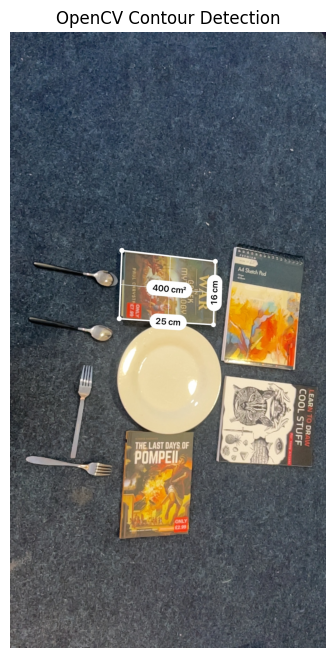

In [ ]:
def run_opencv_object_detection(image_path, known_width_mm=19.05, min_area=3500, draw=True):
  img = cv2.imread(image_path)
  orig = img.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  edged = cv2.Canny(blurred, 50, 100)


  # Finding contours
  cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = sorted(cnts, key=lambda c: cv2.boundingRect(c)[0])

  dimensions = {}
  pixels_per_mm = None

  for i, c in enumerate(cnts):
      if cv2.contourArea(c) < min_area:
          continue

      box = cv2.minAreaRect(c)
      (w_px, h_px) = box[1]
      box_pts = cv2.boxPoints(box)
      box_pts = np.array(box_pts, dtype="int")

      if pixels_per_mm is None:
          ref_width_pixels = min(w_px, h_px)
          pixels_per_mm = ref_width_pixels / known_width_mm
          # print(f"[Reference] Pixels per mm: {pixels_per_mm:.4f}")
          continue

      width_mm = w_px / pixels_per_mm
      height_mm = h_px / pixels_per_mm
      dimensions[i] = (round(width_mm, 2), round(height_mm, 2))

      if draw:
          cv2.drawContours(img, [box_pts], -1, (0, 255, 0), 2)
          center = np.mean(box_pts, axis=0).astype(int)
          label = f"{width_mm:.1f}x{height_mm:.1f}mm"
          cv2.putText(img, label, tuple(center), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)

  if draw:
      plt.figure(figsize=(8, 8))
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.title("OpenCV Contour Detection")
      plt.axis('off')
      plt.show()

  return dimensions, img
run_opencv_object_detection('images/im4-ref4.JPG');

yolo detection


image 1/1 /content/images/im4-ref4.JPG: 640x352 3 spoons, 1 bowl, 2 books, 258.4ms
Speed: 22.3ms preprocess, 258.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)
YOLO Inference Time: 0.59 seconds


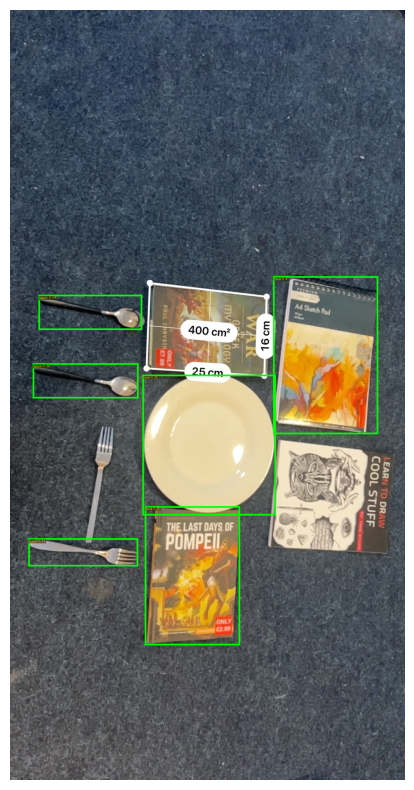

In [ ]:
yolo_model = YOLO("yolov10n.pt")

def yolo_detect(image_path, model=yolo_model, score_threshold=0.2):
    start_time = time.time()
    results = model(image_path)[0]
    end_time = time.time()

    detections = []
    for box in results.boxes:
        score = float(box.conf)
        if score >= score_threshold:
            label_idx = int(box.cls)
            label = model.names[label_idx]
            bbox = box.xyxy[0].tolist()
            detections.append({
                'label': label,
                'bbox': bbox,
                'score': score
            })

    return detections, image_path, end_time - start_time

# Calling the function
detections, img, program_time = yolo_detect('images/im4-ref4.JPG')
print(f"YOLO Inference Time: {program_time:.2f} seconds")
visualize_detections(img, detections)

fastRCNN model detect and visualize

Time for Inference: 9.04 seconds


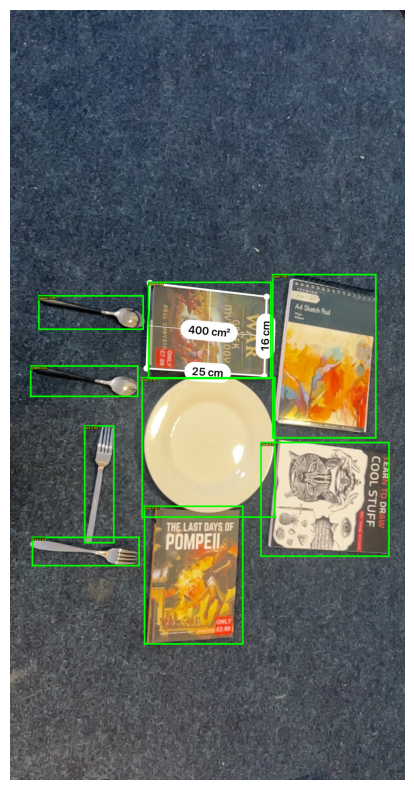

In [ ]:
fasterrcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
fasterrcnn_model.eval()
def fastrcnn_detect(image_path, model=fasterrcnn_model, score_threshold=0.4):
    transform = T.Compose([T.ToTensor()])
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img)

    start_time = time.time()
    with torch.no_grad():
        predictions = model([img_tensor])
    end_time = time.time()

    detections = []
    for i, box in enumerate(predictions[0]['boxes']):
        label_idx = predictions[0]['labels'][i].item()
        label = coco_labels[label_idx]
        score = predictions[0]['scores'][i].item()
        if score >= score_threshold and label != 'N/A':
            detections.append({
                'label': label,
                'bbox': box.tolist(),
                'score': score
            })

    return detections, image_path, end_time - start_time

# Calling the function
detections, img, program_time = fastrcnn_detect('images/im4-ref4.JPG')

print(f'Time for Inference: {program_time:.2f} seconds')
visualize_detections(img, detections)

In [ ]:
# Using the fastrcnn pretrained model

# Loading the model
# !wget https://blog.geraldfrancis.rocks/faster_rcnn_model.pth -O faster_rcnn_model.pth

r = requests.get('https://blog.geraldfrancis.rocks/faster_rcnn_model.pth')
with open('faster_rcnn_model.pth', 'wb') as f:
    f.write(r.content)

# Define the same number of classes (3 + 1 for background)
num_classes = 4  # Book, Plate, Spoon + background

# Load base model
model = fasterrcnn_resnet50_fpn(pretrained=False)

# Replace classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load trained weights
model.load_state_dict(torch.load("faster_rcnn_model.pth", map_location="cpu"))
model.eval()

transform = transforms.Compose([
    transforms.ToTensor()
])

image_path = "images/im4-ref4.JPG"
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image)

# Add batch dimension
input_batch = [image_tensor]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_batch = [img.to(device) for img in input_batch]

# Inference
with torch.no_grad():
    outputs = model(input_batch)
print(outputs)

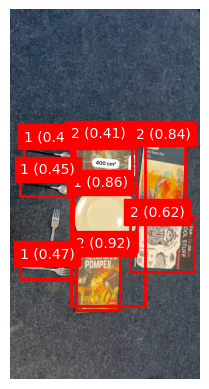

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# COCO-style boxes: [x1, y1, x2, y2]
output = outputs[0]
boxes = output["boxes"]
labels = output["labels"]
scores = output["scores"]

# Filter out low-confidence detections
threshold = 0.4
keep = scores > threshold

fig, ax = plt.subplots(1)
ax.imshow(image)

for box, label, score in zip(boxes[keep], labels[keep], scores[keep]):
    x1, y1, x2, y2 = box.cpu().numpy()
    width, height = x2 - x1, y2 - y1
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f'{label.item()} ({score:.2f})', color='white', backgroundcolor='red', fontsize=10)

plt.axis('off')
plt.show()

In [ ]:
def convert_pixel_to_cm(detections, reference_label="book", ref_width_cm=16, ref_height_cm=25):
    """
    Convert bounding box sizes from pixels to cm using a known reference object.

    Parameters:
        detections (list): List of detection dicts with 'label' and 'bbox'.
        reference_label (str): Label of the reference object (e.g., 'book').
        ref_width_cm (float): Real-world width of the reference object in cm.
        ref_height_cm (float): Real-world height of the reference object in cm.

    Returns:
        list: A list of detections with estimated width and height in cm.
    """
    # Find the first reference object
    ref = next((d for d in detections if d['label'] == reference_label), None)
    if ref is None:
        raise ValueError(f"No reference object '{reference_label}' found in detections.")

    x1, y1, x2, y2 = ref['bbox']
    ref_width_px = x2 - x1
    ref_height_px = y2 - y1

    # Calculate pixel to cm scale
    px_per_cm_w = ref_width_px / ref_width_cm
    px_per_cm_h = ref_height_px / ref_height_cm

    results = []
    for det in detections:
        x1, y1, x2, y2 = det['bbox']
        width_px = x2 - x1
        height_px = y2 - y1

        width_cm = width_px / px_per_cm_w
        height_cm = height_px / px_per_cm_h

        results.append({
            'label': det['label'],
            'score': det['score'],
            'width': round(width_cm, 2),
            'height': round(height_cm, 2)
        })

    return results

In [ ]:
results = convert_pixel_to_cm(detections)
for r in results:
    print(f"{r['label']} | {r['width']} cm x {r['height']} cm (score: {r['score']:.2f})")
data = pd.DataFrame(results)
data.to_csv('results.csv', index=False)
data

fork | 4.73 cm x 21.18 cm (score: 0.99)
book | 16.0 cm x 25.0 cm (score: 0.97)
spoon | 17.42 cm x 5.55 cm (score: 0.95)
fork | 17.34 cm x 5.14 cm (score: 0.94)
spoon | 16.95 cm x 6.04 cm (score: 0.88)
book | 16.79 cm x 29.68 cm (score: 0.86)
book | 20.84 cm x 20.63 cm (score: 0.75)
bowl | 21.63 cm x 25.3 cm (score: 0.45)
book | 19.91 cm x 17.5 cm (score: 0.44)


,label,score,width,height
0,fork,0.991969,4.73,21.18
1,book,0.969009,16.00,25.00
2,spoon,0.951425,17.42,5.55
3,fork,0.936465,17.34,5.14
4,spoon,0.882915,16.95,6.04
5,book,0.855214,16.79,29.68
6,book,0.749696,20.84,20.63
7,bowl,0.450284,21.63,25.30
8,book,0.444694,19.91,17.50


In [ ]:
test_container = (100,100)

# Our algorithm cant take floating points. so we round off
print("Generated test_item_list:")
test_item_list = {f'item_{i}': (int(row['width']), int(row['height'])) for i, row in data.iterrows()}
test_item_list

{'item_0': (4, 21),
 'item_1': (16, 25),
 'item_2': (17, 5),
 'item_3': (17, 5),
 'item_4': (16, 6),
 'item_5': (16, 29),
 'item_6': (20, 20),
 'item_7': (21, 25),
 'item_8': (19, 17)}

Using FastRCNN pretrained model

### Running pretrainend model

In [ ]:
"""
Function to filter atleast a sample of 100 images for training the model
"""
target_classes = ["Plate", "Spoon", "Book"]
classes = pd.read_csv("class-descriptions-boxable.csv", header=None)
target_label_names = classes[classes[1].isin(target_classes)][0].tolist()

# Load full annotations
full_annots = pd.read_csv("train-annotations-bbox.csv")

# Filter annotations for only those target classes
filtered_annots = full_annots[full_annots['LabelName'].isin(target_label_names)]

# Select the first 100 unique images
selected_image_ids = filtered_annots['ImageID'].unique()[:100]

subset_annots = filtered_annots[filtered_annots['ImageID'].isin(selected_image_ids)]

selected_image_ids = filtered_annots['ImageID'].unique()[:100]
subset_annots = filtered_annots[filtered_annots['ImageID'].isin(selected_image_ids)]

subset_annots.to_csv("subset-annotations.csv", index=False)

import os
import shutil

source_folder = "custom_images"
target_folder = "custom_images_100"
os.makedirs(target_folder, exist_ok=True)

for img_id in selected_image_ids:
    src_path = os.path.join(source_folder, f"{img_id}.jpg")
    dst_path = os.path.join(target_folder, f"{img_id}.jpg")
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

Loading the dataset.

In [ ]:
'''
This class definition to Load the Open Images Dataset.
'''
class OpenImagesDataset(Dataset):
    def __init__(self, root, annotation_csv, classes_csv, target_classes, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annots = pd.read_csv(annotation_csv)
        self.classes = pd.read_csv(classes_csv, header=None)

        # Get target label codes
        self.target_classes = target_classes
        self.label_names = self.classes[self.classes[1].isin(target_classes)][0].tolist()

        # Filter only relevant annotations
        self.annots = self.annots[self.annots['LabelName'].isin(self.label_names)]
        self.image_ids = self.annots['ImageID'].unique()

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.root, image_id + '.jpg')
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        image_annots = self.annots[self.annots['ImageID'] == image_id]
        for _, row in image_annots.iterrows():
            xmin = row['XMin'] * img.width
            xmax = row['XMax'] * img.width
            ymin = row['YMin'] * img.height
            ymax = row['YMax'] * img.height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.label_names.index(row['LabelName']) + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)

# Transformations
transform = T.Compose([T.ToTensor()])

# Target classes
target_classes = ["Plate", "Spoon", "Book"]

# Dataset and DataLoader
dataset = OpenImagesDataset(
    root="custom_images_100",
    annotation_csv="subset-annotations.csv",
    classes_csv="class-descriptions-boxable.csv",
    target_classes=target_classes,
    transforms=transform
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the box predictor
num_classes = len(target_classes) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

training the model

In [ ]:
from tqdm import tqdm, trange

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 5

for epoch in trange(num_epochs, desc="Epochs"):
    model.train()
    running_loss = 0.0

    for images, targets in tqdm(data_loader, desc=f"Training Epoch {epoch+1}", leave=False):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    avg_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}")
    torch.save(model.state_dict(), f'faster_rcnn_model_epoch_{epoch+1}.pth')

Saving the model

In [ ]:
torch.save(model.state_dict(), 'faster_rcnn_model.pth')

Placing Algorithm

In [ ]:
os.makedirs('./input/Elhedhli_dataset', exist_ok=True)
url = 'https://raw.githubusercontent.com/ocansey11/computer-vision/main/Q4RealBPP_DataGen.py'
local_path = './Q4RealBPP_DataGen.py'
urllib.request.urlretrieve(url, local_path)

# Import dynamically
spec = importlib.util.spec_from_file_location("Q4RealBPP_DataGen", local_path)
Q4RealBPP_DataGen = importlib.util.module_from_spec(spec)
spec.loader.exec_module(Q4RealBPP_DataGen)

ProductDataset = Q4RealBPP_DataGen.ProductDataset

In [ ]:
pkl_url = 'https://raw.githubusercontent.com/ocansey11/computer-vision/main/Elhedhli_dataset/products.pkl'
local_pkl = './products.pkl'
urllib.request.urlretrieve(pkl_url, local_pkl)

# Load and preprocess
df = pd.read_pickle(local_pkl)
df = df[['width', 'depth', 'weight']]
df.rename(columns={'depth': 'height'}, inplace=True)
df['id'] = ['item_' + str(i) for i in range(len(df))]


In [ ]:
df.head()

,width,height,weight,id
0,284,226,25,item_0
1,299,207,90,item_1
2,534,372,41,item_2
3,295,134,31,item_3
4,266,186,54,item_4


In [ ]:
import numpy as np
def generate_2d_item_list(
    num_items=10,
    bin_width=1000,
    bin_height=1000,
    min_dim=100,
    max_dim=400,
    min_weight=1,
    max_weight=10,
    seed=42,
):
    """
    Generate a synthetic 2D test case of items for packing.

    Parameters
    ----------
    num_items : int
        Number of items to generate.
    bin_width, bin_height : int
        Dimensions of the container (for reference).
    min_dim, max_dim : int
        Min and max for width/height of items.
    min_weight, max_weight : int
        Min and max weight for each item.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    container : tuple
        (height, width) of the bin/container.
    item_list : dict
        Mapping from item_id to (height, width) tuple.
    """
    np.random.seed(seed)

    instance = ProductDataset(
        products_path='./input/Elhedhli_dataset/products.pkl',
        num_categories=num_items,
        min_width=min_dim,
        max_width=max_dim,
        min_depth=min_dim,
        max_depth=max_dim,
        min_height=0,     # Ignored for 2D
        max_height=0,
        min_weight=min_weight,
        max_weight=max_weight,
        force_overload=True
    )

    df = instance.products
    df = df[['width', 'depth']]
    df.rename(columns={'depth': 'height'}, inplace=True)
    df['id'] = ['item_' + str(i) for i in range(len(df))]

    # Convert to item_list format: {item_id: (height, width)}
    item_list = {row['id']: (row['height'], row['width']) for _, row in df.iterrows()}

    container = (bin_height, bin_width)
    return container, item_list


In [ ]:
def plot_2d_solution(container, layout_df):
    """
    Visualize the 2D layout of packed items inside a container.

    This function creates a matplotlib plot of the container with each packed item
    represented as a colored rectangle. Each item is annotated with its ID.

    Parameters
    ----------
    container : dict
        A dictionary specifying the dimensions of the container. Should contain:
            - 'width' : int or float, the container's width.
            - 'height': int or float, the container's height.

    layout_df : pandas.DataFrame
        A DataFrame with the placement information for each item. Must contain columns:
            - 'x'      : x-coordinate (left) of the item's position.
            - 'y'      : y-coordinate (top) of the item's position.
            - 'width'  : width of the item.
            - 'height' : height of the item.
            - 'id'     : identifier of the item (used for labeling).

    Returns
    -------
    None
        Displays a matplotlib plot showing the packing layout.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, container['width'])
    ax.set_ylim(0, container['height'])
    ax.set_title('2D Knapsack Layout')
    ax.set_aspect('equal')

    for _, row in layout_df.iterrows():
        rect = patches.Rectangle(
            (row['x'], row['y']),
            row['width'],
            row['height'],
            linewidth=1,
            edgecolor='black',
            facecolor=np.random.rand(3,)
        )
        ax.add_patch(rect)
        ax.text(row['x'] + 5, row['y'] + 5, row['id'], fontsize=8)

    plt.gca().invert_yaxis()
    plt.show()


In [ ]:
def greedy_tetris_packing_with_fail(container_size, item_list, grid_unit=20):
    """
    Attempts to pack items into a 2D container using a greedy placement strategy.

    This is the core helper function for follow up genetic algorithm for 2d bin placement 2D bin packing. Items are sorted
    by width (in grid units) and placed top-left first. Items that cannot be placed due to space or collision constraints are returned separately.

    Parameters
    ----------
    container_size : tuple of int
        The (height, width) of the container in real units (e.g., pixels, cm).

    item_list : dict
        Dictionary mapping item IDs to their (height, width) in real units.

    grid_unit : int, optional
        The size of each discrete grid cell. Both container and items are discretized
        using this unit to simplify placement logic (default is 20).

    Returns
    -------
    placements : list of dict
        Each dict contains:
            - 'item'   : item ID
            - 'row'    : top Y coordinate (in real units)
            - 'col'    : left X coordinate (in real units)
            - 'height' : item height (in real units)
            - 'width'  : item width (in real units)

    unplaced_items : list
        A list of item IDs that could not be placed in the container.
    """
    H, W = int(container_size[0] // grid_unit), int(container_size[1] // grid_unit)
    grid = [[0 for _ in range(W)] for _ in range(H)]

    # Convert dimensions to grid units and sort by width (descending)
    items = sorted(
        [(i, max(1, round(h / grid_unit)), max(1, round(w / grid_unit)))
         for i, (h, w) in item_list.items()],
        key=lambda x: x[2], reverse=True
    )

    placements = []
    unplaced_items = []

    for item_id, h, w in items:
        placed = False
        for r in range(H):
            for c in range(W):
                if can_place(grid, r, c, h, w, H, W):
                    place_item(grid, r, c, h, w, item_id)
                    placements.append({
                        'item': item_id,
                        'row': r * grid_unit,
                        'col': c * grid_unit,
                        'height': h * grid_unit,
                        'width': w * grid_unit
                    })
                    placed = True
                    break
            if placed:
                break
        if not placed:
            unplaced_items.append(item_id)

    return placements, unplaced_items


def can_place(grid, r, c, h, w, H, W):
    """
    Checks whether an item of height h and width w can be placed at (r, c) on the grid.

    Ensures the item stays within bounds and does not overlap with any existing items.

    Parameters
    ----------
    grid : list of list of int
        2D grid representing container occupancy.
    r, c : int
        Row and column to attempt placing the item.
    h, w : int
        Item height and width in grid units.
    H, W : int
        Total height and width of the grid.

    Returns
    -------
    bool
        True if the item can be placed without collisions or overflow.
    """
    if r + h > H or c + w > W:
        return False
    for i in range(r, r + h):
        for j in range(c, c + w):
            if grid[i][j] != 0:
                return False
    return True


def place_item(grid, r, c, h, w, item_id):
    """
    Places an item on the grid by marking its occupied cells with the item ID.

    Parameters
    ----------
    grid : list of list of int
        2D grid representing container occupancy.
    r, c : int
        Top-left grid cell where the item will be placed.
    h, w : int
        Item height and width in grid units.
    item_id : int or str
        Identifier for the item to mark on the grid.

    Returns
    -------
    None
    """
    for i in range(r, r + h):
        for j in range(c, c + w):
            grid[i][j] = item_id


In [ ]:
def genetic_algorithm_packing(container_size, item_list, grid_unit=20,
                              population_size=10, generations=20, mutation_rate=0.1,
                              visualize=True):
    """
    Optimize item packing using a Genetic Algorithm.

    Parameters
    ----------
    container_size : tuple
        (height, width) of the container.
    item_list : dict
        Mapping of item_id to (height, width).
    grid_unit : int
        Grid discretization unit.
    population_size : int
        Number of candidate solutions per generation.
    generations : int
        Total number of evolution steps.
    mutation_rate : float
        Probability of mutation per child.
    visualize : bool
        If True, plots the best packing layout.

    Returns
    -------
    dict
        Contains best_individual, best_placements, best_unplaced, best_score.
    """
    def evaluate(individual):
        """
        Evaluate the fitness of an individual permutation.

        Returns cost, placements, and list of unplaced items.
        """
        shuffled_items = {i: item_list[i] for i in individual}
        placements, unplaced = greedy_tetris_packing_with_fail(container_size, shuffled_items, grid_unit)

        total_area = sum([h * w for _, h, w in [(i, max(1, round(item_list[i][0] / grid_unit)),
                                                 max(1, round(item_list[i][1] / grid_unit)))
                                                for i in item_list]])
        used_area = sum([p['height'] * p['width'] for p in placements])
        cost = len(unplaced) * 1000 + (total_area - used_area)
        return cost, placements, unplaced

    item_ids = list(item_list.keys())
    population = [random.sample(item_ids, len(item_ids)) for _ in range(population_size)]
    best_individual, best_placements, best_unplaced = None, [], []
    best_score = float('inf')

    print("Starting Genetic Algorithm...")
    start_time = time.time()

    for gen in tqdm(range(generations), desc="Evolving generations"):
        scored_population = []
        for individual in population:
            cost, placements, unplaced = evaluate(individual)
            scored_population.append((cost, individual, placements, unplaced))
            if cost < best_score:
                best_score = cost
                best_individual = individual
                best_placements = placements
                best_unplaced = unplaced

        scored_population.sort(key=lambda x: x[0])
        survivors = scored_population[:population_size // 2]

        children = []
        while len(children) < population_size - len(survivors):
            parent1 = random.choice(survivors)[1]
            parent2 = random.choice(survivors)[1]
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate)
            children.append(child)

        population = [s[1] for s in survivors] + children

    end_time = time.time()
    print(f"\n Genetic algorithm finished in {end_time - start_time:.2f} seconds.")
    print(f"Best Cost = {best_score}, Unplaced Items = {len(best_unplaced)}")

    if visualize and best_placements:
        layout_df = pd.DataFrame(best_placements).rename(columns={'col': 'x', 'row': 'y'})
        layout_df['id'] = layout_df['item'].astype(str)
        plot_2d_solution(container={'width': container_size[1], 'height': container_size[0]},
                         layout_df=layout_df)

    return {
        'best_individual': best_individual,
        'best_placements': best_placements,
        'best_unplaced': best_unplaced,
        'best_score': best_score
    }


def crossover(parent1, parent2):
    """
    Order crossover (OX) between two parents.

    Parameters
    ----------
    parent1, parent2 : list
        Two parent permutations.

    Returns
    -------
    list
        New child permutation.
    """
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child = [None] * size
    child[start:end] = parent1[start:end]

    fill_positions = [item for item in parent2 if item not in child]
    pointer = 0
    for i in range(size):
        if child[i] is None:
            child[i] = fill_positions[pointer]
            pointer += 1
    return child


def mutate(individual, mutation_rate):
    """
    Randomly swaps two items in the individual based on mutation rate.

    Parameters
    ----------
    individual : list
        Permutation of item IDs.
    mutation_rate : float
        Probability of mutation.

    Returns
    -------
    list
        Mutated individual.
    """
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(individual)), 2)
        individual[i], individual[j] = individual[j], individual[i]
    return individual


In [ ]:
def greedy_tetris_packing_with_rotation(container_size, item_list, grid_unit=20):
    H, W = int(container_size[0] // grid_unit), int(container_size[1] // grid_unit)
    grid = [[0 for _ in range(W)] for _ in range(H)]

    items = sorted(
        [(i, max(1, round(h / grid_unit)), max(1, round(w / grid_unit)))
         for i, (h, w) in item_list.items()],
        key=lambda x: x[2], reverse=True
    )

    placements = []
    unplaced_items = []

    for item_id, h, w in items:
        placed = False
        orientations = [(h, w, False), (w, h, True)]  # Try both orientations
        for height, width, rotated in orientations:
            for r in range(H):
                for c in range(W):
                    if can_place(grid, r, c, height, width, H, W):
                        place_item(grid, r, c, height, width, item_id)
                        placements.append({
                            'item': item_id,
                            'row': r * grid_unit,
                            'col': c * grid_unit,
                            'height': height * grid_unit,
                            'width': width * grid_unit,
                            'rotated': rotated
                        })
                        placed = True
                        break
                if placed:
                    break
            if placed:
                break
        if not placed:
            unplaced_items.append(item_id)

    return placements, unplaced_items


In [ ]:
import random
import math
import time
from tqdm import tqdm
import pandas as pd

def simulated_annealing_packing(container_size, item_list, grid_unit=20, initial_temp=1000, cooling_rate=0.95, max_iter=1000, visualize=True, track_progress=False):
    item_ids = list(item_list.keys())
    current_order = random.sample(item_ids, len(item_ids))

    current_placements, current_unplaced = greedy_tetris_packing_with_rotation(container_size, {i: item_list[i] for i in current_order}, grid_unit)
    current_cost = compute_cost(current_placements, current_unplaced, item_list, grid_unit)

    best_order = current_order[:]
    best_cost = current_cost
    best_placements = current_placements
    best_unplaced = current_unplaced

    temp = initial_temp
    cost_trace = []

    print("Starting Simulated Annealing...")
    start_time = time.time()

    for step in tqdm(range(max_iter), desc="Annealing steps"):
        neighbor_order = current_order[:]
        i, j = random.sample(range(len(neighbor_order)), 2)
        neighbor_order[i], neighbor_order[j] = neighbor_order[j], neighbor_order[i]

        neighbor_placements, neighbor_unplaced = greedy_tetris_packing_with_rotation(container_size, {i: item_list[i] for i in neighbor_order}, grid_unit)
        neighbor_cost = compute_cost(neighbor_placements, neighbor_unplaced, item_list, grid_unit)

        delta = neighbor_cost - current_cost

        if delta < 0 or random.random() < math.exp(-delta / temp):
            current_order = neighbor_order
            current_cost = neighbor_cost
            current_placements = neighbor_placements
            current_unplaced = neighbor_unplaced

            if current_cost < best_cost:
                best_order = current_order[:]
                best_cost = current_cost
                best_placements = current_placements
                best_unplaced = current_unplaced

        temp *= cooling_rate
        if track_progress:
            cost_trace.append(best_cost)

    end_time = time.time()
    print(f"\n Simulated Annealing finished in {end_time - start_time:.2f} seconds.")
    print(f"Best Cost = {best_cost}, Unplaced Items = {len(best_unplaced)}")

    # Optional plot of layout
    if visualize and best_placements:
        layout_df = pd.DataFrame(best_placements).rename(columns={'col': 'x', 'row': 'y'})
        layout_df['id'] = layout_df['item'].astype(str)
        plot_2d_solution(
            container={'width': container_size[1], 'height': container_size[0]},
            layout_df=layout_df
        )


    return {
        'best_order': best_order,
        'best_placements': best_placements,
        'best_unplaced': best_unplaced,
        'best_cost': best_cost,
        'cost_trace': cost_trace if track_progress else None
    }
#

Creating our test Case Using benchmark Dataset

Starting Genetic Algorithm...


Evolving generations: 100%|██████████| 15/15 [01:32<00:00,  6.15s/it]


 Genetic algorithm finished in 92.26 seconds.
Best Cost = -781311, Unplaced Items = 10


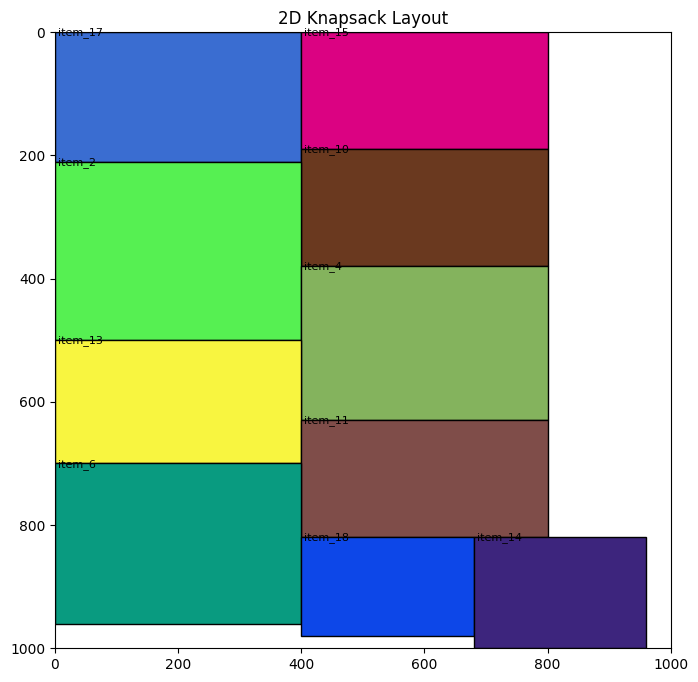

In [ ]:
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches


container, item_list = generate_2d_item_list(20)

ga_result = genetic_algorithm_packing(container_size=(1000, 1000), item_list=item_list, grid_unit=10, population_size=100, generations=15, mutation_rate=0.5)

In [ ]:
ga_result

{'best_individual': [17,
  10,
  8,
  4,
  6,
  7,
  0,
  1,
  11,
  18,
  2,
  9,
  14,
  19,
  3,
  15,
  13,
  5,
  12,
  16],
 'best_placements': [{'item': 17,
   'row': 0,
   'col': 0,
   'height': 210,
   'width': 400},
  {'item': 10, 'row': 0, 'col': 400, 'height': 190, 'width': 400},
  {'item': 4, 'row': 190, 'col': 400, 'height': 250, 'width': 400},
  {'item': 6, 'row': 210, 'col': 0, 'height': 260, 'width': 400},
  {'item': 7, 'row': 440, 'col': 400, 'height': 190, 'width': 400},
  {'item': 1, 'row': 470, 'col': 0, 'height': 200, 'width': 400},
  {'item': 11, 'row': 630, 'col': 400, 'height': 190, 'width': 400},
  {'item': 2, 'row': 670, 'col': 0, 'height': 290, 'width': 400},
  {'item': 18, 'row': 820, 'col': 400, 'height': 160, 'width': 280},
  {'item': 14, 'row': 820, 'col': 680, 'height': 180, 'width': 280}],
 'best_unplaced': [15, 13, 0, 5, 3, 8, 9, 19, 16, 12],
 'best_score': -781311}

Starting Simulated Annealing...


Annealing steps: 100%|██████████| 500/500 [00:06<00:00, 77.57it/s]



 Simulated Annealing finished in 6.45 seconds.
Best Cost = -949660, Unplaced Items = 8


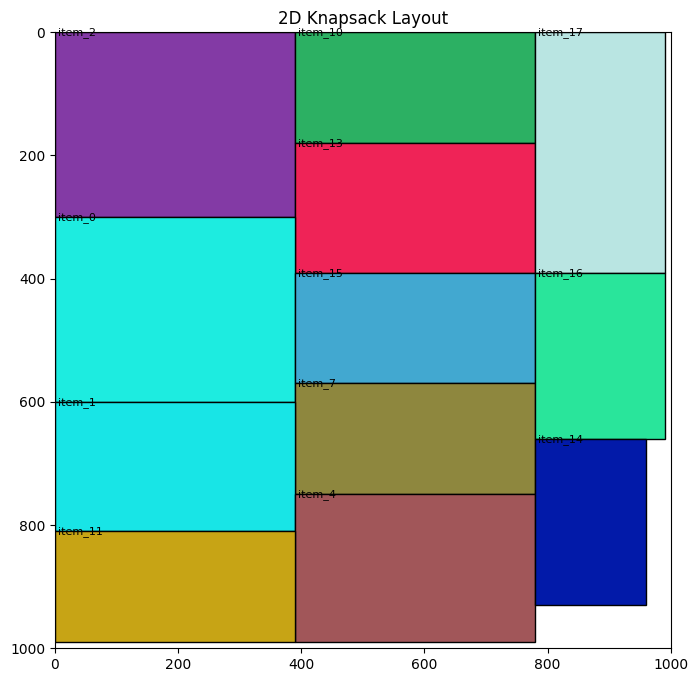

In [ ]:
sa_result = simulated_annealing_packing(
    container_size=(1000, 1000),
    item_list=item_list,
    grid_unit=30,
    initial_temp=500,
    cooling_rate=0.98,
    max_iter=500,
    track_progress=True
)


In [ ]:
sa_result

{'best_order': [2,
  15,
  11,
  4,
  7,
  8,
  12,
  9,
  16,
  0,
  1,
  14,
  6,
  17,
  13,
  18,
  5,
  10,
  19,
  3],
 'best_placements': [{'item': 2,
   'row': 0,
   'col': 0,
   'height': 300,
   'width': 390,
   'rotated': False},
  {'item': 15,
   'row': 0,
   'col': 390,
   'height': 180,
   'width': 390,
   'rotated': False},
  {'item': 11,
   'row': 180,
   'col': 390,
   'height': 180,
   'width': 390,
   'rotated': False},
  {'item': 4,
   'row': 300,
   'col': 0,
   'height': 240,
   'width': 390,
   'rotated': False},
  {'item': 7,
   'row': 360,
   'col': 390,
   'height': 180,
   'width': 390,
   'rotated': False},
  {'item': 0,
   'row': 540,
   'col': 0,
   'height': 300,
   'width': 390,
   'rotated': False},
  {'item': 1,
   'row': 540,
   'col': 0,
   'height': 210,
   'width': 390,
   'rotated': False},
  {'item': 6,
   'row': 540,
   'col': 390,
   'height': 270,
   'width': 390,
   'rotated': False},
  {'item': 17,
   'row': 750,
   'col': 0,
   'height': 21

Running Tests on item generated

Starting Genetic Algorithm...


Evolving generations: 100%|██████████| 15/15 [00:00<00:00, 98.37it/s]


 Genetic algorithm finished in 0.16 seconds.
Best Cost = 830, Unplaced Items = 3


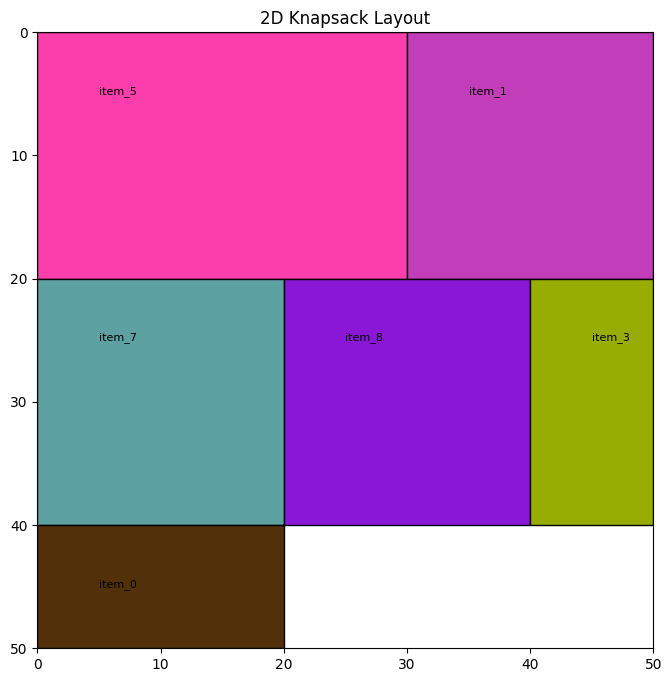

In [ ]:
test_container=(50,50)
test_item_list
ga_results_test =  genetic_algorithm_packing(test_container, item_list=test_item_list, grid_unit=10, population_size=100, generations=15, mutation_rate=0.5)

Tweak the variables based on the context for better prformance

Starting Simulated Annealing...


Annealing steps: 100%|██████████| 500/500 [00:00<00:00, 15280.02it/s]


 Simulated Annealing finished in 0.04 seconds.
Best Cost = 3409, Unplaced Items = 5


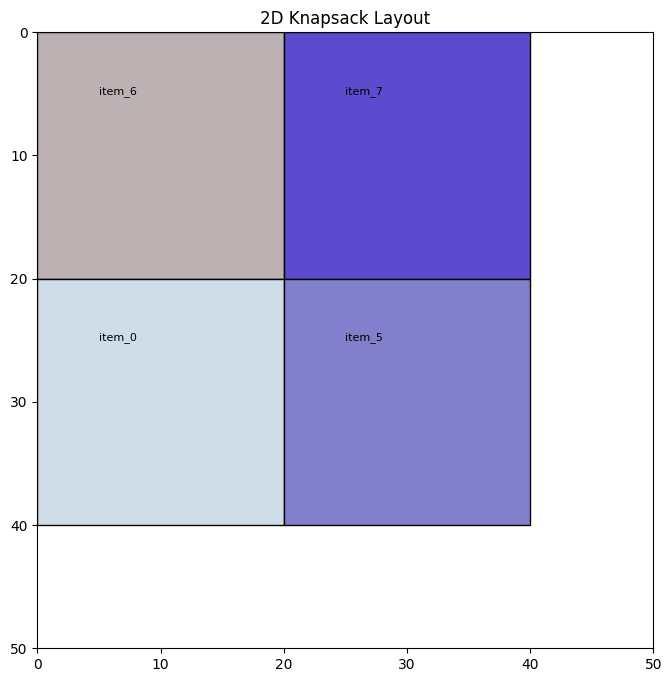

In [ ]:
test_container=(50,50)
test_item_list
sa_results_test = simulated_annealing_packing(
    test_container,
    test_item_list,
    grid_unit=20,
    initial_temp=1000,
    cooling_rate=0.98,
    max_iter=500,
    track_progress=True
)

###Appendix: Preprocessing Steps <a id="appendix-preprocessing"></a>


## References

1. Hertrich, C. and Skutella, M., 2023. *Provably Good Solutions to the Knapsack Problem via Neural Networks of Bounded Size*. INFORMS Journal on Computing, 35(5), pp.1079–1097.

2. Plotkin, A. V., 2022. *Fast algorithm for quadratic knapsack problem*. Vestnik of Saint Petersburg University. Mathematics. Mechanics. Astronomy, 9(1), pp.76–84.

3. Fomeni, F. D. and Letchford, A. N., 2014. *A Dynamic Programming Heuristic for the Quadratic Knapsack Problem*. INFORMS Journal on Computing, 26(1), pp.173–182. Available from: https://dx.doi.org/10.1287/ijoc.2013.0555.

4. Le, A. V. et al., 2018. *Complete Path Planning for a Tetris-Inspired Self-Reconfigurable Robot by the Genetic Algorithm of the Traveling Salesman Problem*. Electronics, 7(12), p.344. Available from: https://dx.doi.org/10.3390/electronics7120344.

5. Tan, L. et al., 2021. *Comparison of YOLO v3, Faster R-CNN, and SSD for Real-Time Pill Identification*.

6. Hanif, M. Z. et al., 2024. *Rupiah Banknotes Detection Comparison of The Faster R-CNN Algorithm and YOLOv5*. JURNAL INFOTEL, 16(3).

7. Vilcapoma, P. et al., 2024. *Comparison of Faster R-CNN, YOLO, and SSD for Third Molar Angle Detection in Dental Panoramic X-rays*. Sensors, 24(18), p.6053.

8. Nedashkivskyi, S., 2024. *Using Convolutional Neural Networks for Solving Problems of Object Detection*. Věda a perspektivy, 5(36).

9. He, Z. and He, Y., 2025. *AS-Faster-RCNN: An Improved Object Detection Algorithm for Airport Scene Based on Faster R-CNN*. IEEE Access, 13, pp.36050–36064.

10. Munapo, E., 2020. *Improvement of the branch and bound algorithm for solving the knapsack linear integer problem*. Eastern-European Journal of Enterprise Technologies, 2(4(104)), pp.59–69.

11. Kang, S. et al., 2024. *Theoretical analysis of integer programming models for the two-dimensional two-staged knapsack problem*. Optimization Letters.

12. Li, M. et al., 2024. *TA-YOLO: a lightweight small object detection model based on multi-dimensional trans-attention module for remote sensing images*. Complex & Intelligent Systems, 10(4), pp.5459–5473.

13. Othman, N. A. et al., 2018. *An Embedded Real-Time Object Detection and Measurement of its Size*. 2018 International Conference on Artificial Intelligence and Data Processing (IDAP), Malatya, Turkey, pp.1–4. doi:10.1109/IDAP.2018.8620812.

14. Singh, K. et al., 2023. *Surface Area Calculation of Asymmetric/Axisymmetric Shapes Utilising Simple Image Processing and OpenCV*. 2023 7th International Conference On Computing, Communication, Control And Automation (ICCUBEA), Pune, India, pp.1–8. doi:10.1109/ICCUBEA58933.2023.10392058.

15. Hanif, M.Z., Saputra, W.A., Choo, Y.H. and Yunus, A.P., 2020. A neural network-based approach to solving the knapsack problem. *IEEE Access*, [online] Available at: <https://ieeexplore.ieee.org/document/9291401> [Accessed 14 May 2025].

16. Franco, C., Gonçalves, J., Silva, S. and Machado, P., 2016. How humans solve the knapsack problem: A study using eye-tracking. *Scientific Reports*, 6, p.34851. Available at: <https://www.nature.com/articles/srep34851> [Accessed 14 May 2025].

17. Martello, S. and Toth, P., 1990. Knapsack problems: algorithms and computer implementations. Chichester: Wiley.

18. Mitchell, M., 1998. An introduction to genetic algorithms. Cambridge, Mass.: MIT Press.

19. Silva, D.F., da Silva, J.S. and Miyata, H., 2021. ‘A review of two-dimensional packing problems and solution techniques’. Computers & Industrial Engineering, 154, p.107111.

20. Elhedhli, S., Gzara, F. & Yildiz, B., 2019. Three-dimensional bin packing and mixed-case palletization. INFORMS Journal on Optimization, 1(4), pp.323–352.

21. TECNALIA, 2023. Q4RealBPP: A Data Generator for Bin Packing Problems [Python script]. Available at: https://github.com/TECNALIA/Q4RealBPP [Accessed 21 04 2025].

22. Murawski, C. and Bossaerts, P., 2016. How Humans Solve Complex Problems: The Case of the Knapsack Problem. Scientific Reports [online], 6 (1), 34851. Available from: https://dx.doi.org/10.1038/srep34851.


